##1. Imports

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from collections import Counter 

##2. Display Image

In [2]:
def display_image(image_path):
    """This function takes the image path and displays the image
     with full figure"""
    dpi = 80  # Dots Per Inch
    image_data = plt.imread(image_path)
    height, width = image_data.shape[:2]
    # size the figure need to be in inches to fit the image
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    ax.imshow(image_data, cmap='gray')
    plt.show()

##3. Align Text Image

In [3]:
class AlignTextImage:
    """ Align the images perfectly with vertical and horizontal axes."""
    def __init__(self, image):
        self.image = image

    def getSkewAngle(self):
        """ This function calculates the angle of skewness of image"""
        newImage = self.image.copy()
        gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (9, 9), 0)
        thresh = cv2.threshold(
            blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        # dilate to merge text into meaningful lines/paragraphs.
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 1))
        dilate = cv2.dilate(thresh, kernel, iterations=2)
        cv2.imwrite('/content/drive/My Drive/misaligned_images/dilate.jpg', 
                    dilate)
        # Find all contours
        contours, hierarchy = cv2.findContours(
            dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        for c in contours:
            rect = cv2.boundingRect(c)
            x, y, w, h = rect
            cv2.rectangle(newImage, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Save image with contours for vizualization
        filepath = '/content/drive/My Drive/misaligned_images/boxes.jpg'
        cv2.imwrite(filepath, newImage)

        # determining angle using top 5 largest contours
        allContourAngles = [cv2.minAreaRect(c)[-1] for c in contours[:5]]
        for idx, angle in enumerate(allContourAngles):
            if angle < -45:
                allContourAngles[idx] = 90 + angle

        # Choose most frequent close values, it seems to work best.
        new_list = [round(a) for a in allContourAngles]
        occurence_count = Counter(new_list)
        most_common = occurence_count.most_common(1)[0][0]
        idx = new_list.index(most_common)
        angle = allContourAngles[idx]

        return -1.0 * angle

    def rotateImage(self, angle):
        """Rotate the image as per the angle"""
        newImage = self.image.copy()
        (h, w) = newImage.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC,
                                  borderMode=cv2.BORDER_REPLICATE)
        return newImage

    def deskew(self):
        angle = self.getSkewAngle()
        return self.rotateImage(-1.0 * angle)

##4. Transform image and visualize the steps

In [10]:
# Deskew one image from the list 
path = '/content/drive/My Drive/misaligned_images/data/5.jpg'
image = cv2.imread(path)
align_obj = AlignTextImage(image)
aligned_image = align_obj.deskew()
dest_path = '/content/drive/My Drive/misaligned_images/5_aligned.jpg'
cv2.imwrite(dest_path, aligned_image)

True

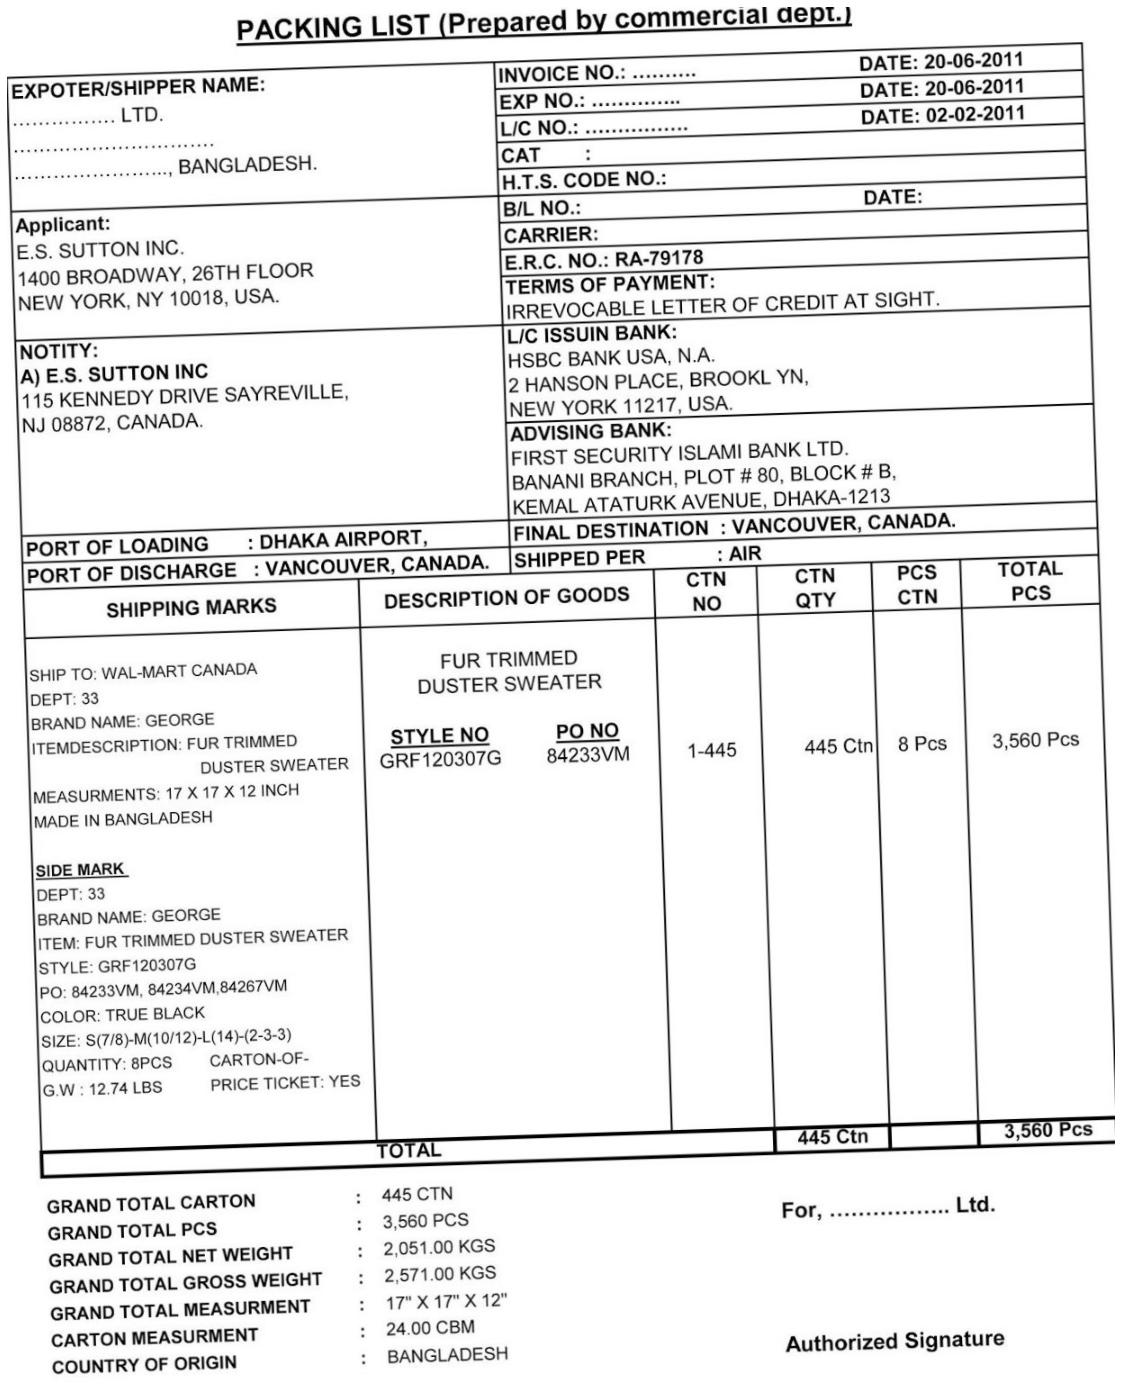

In [11]:
# lets visualize the original image, dilated image and aligned image
display_image(path)

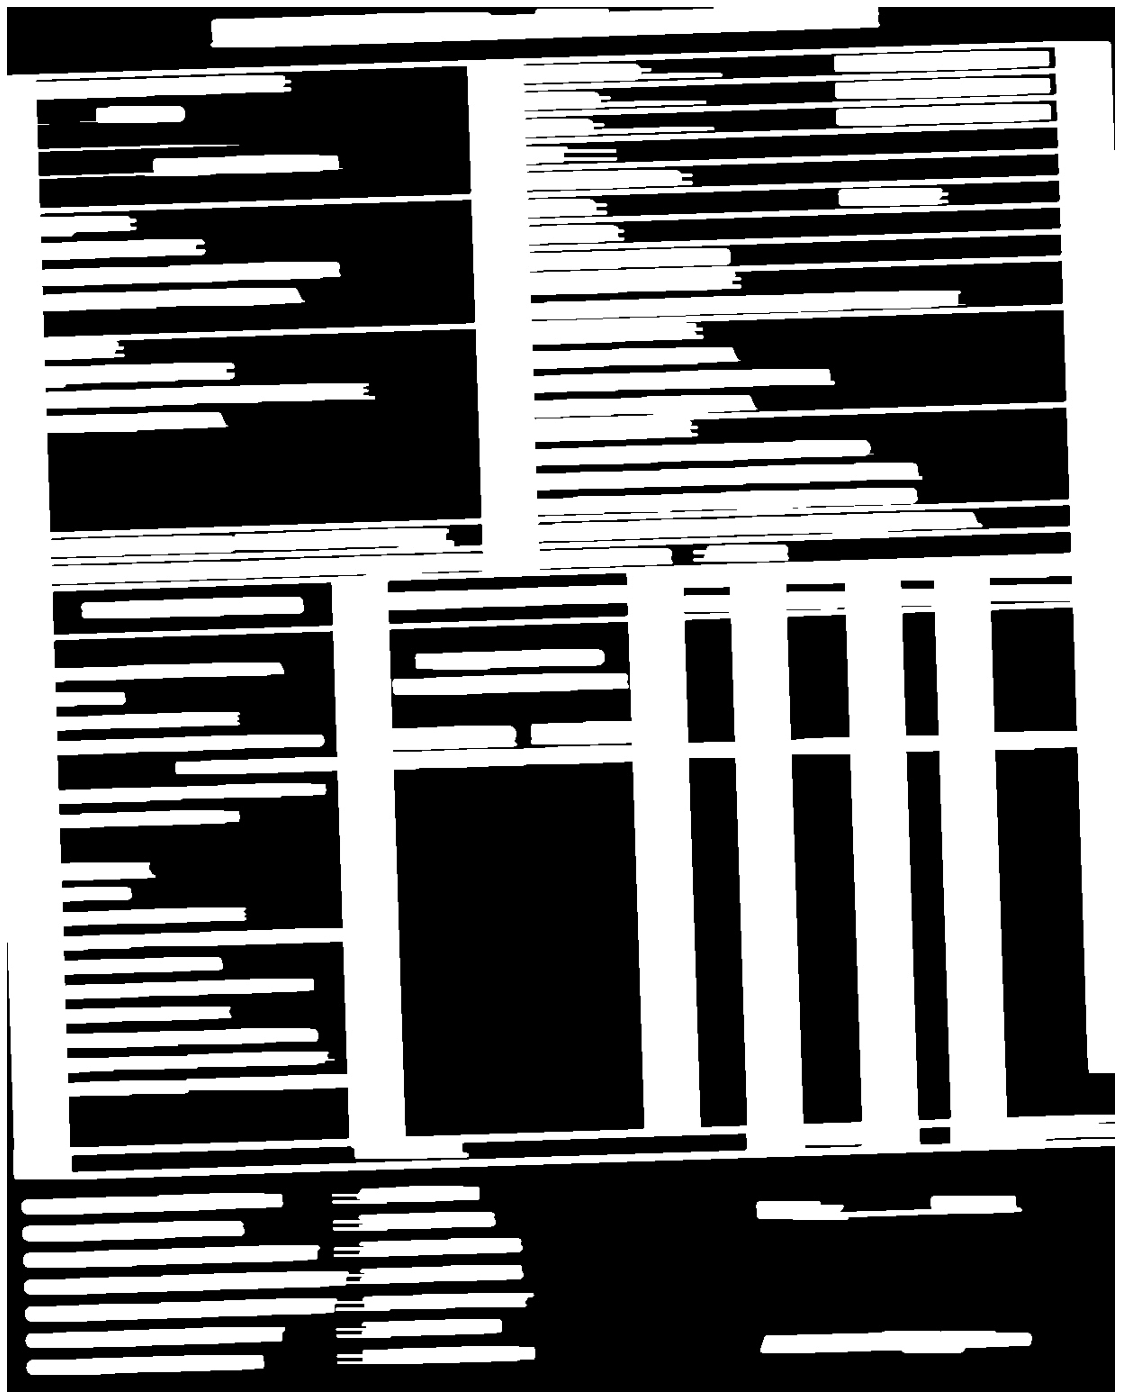

In [12]:
# display the dilated image
display_image('/content/drive/My Drive/misaligned_images/dilate.jpg')

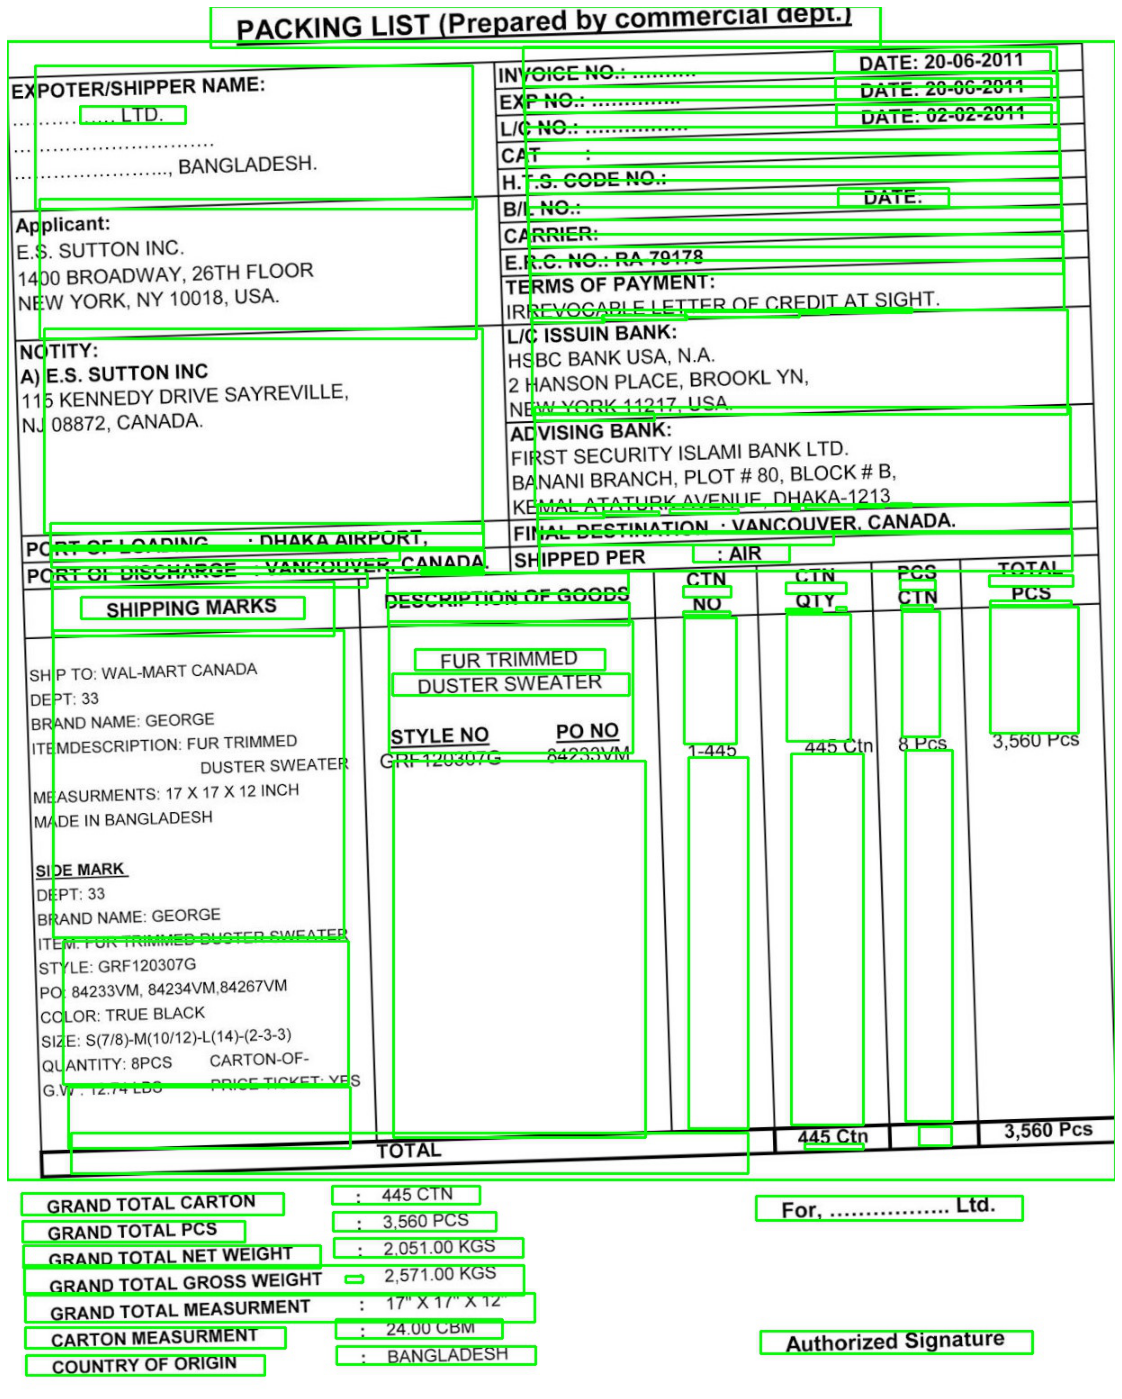

In [13]:
# display the contours
display_image('/content/drive/My Drive/misaligned_images/boxes.jpg')

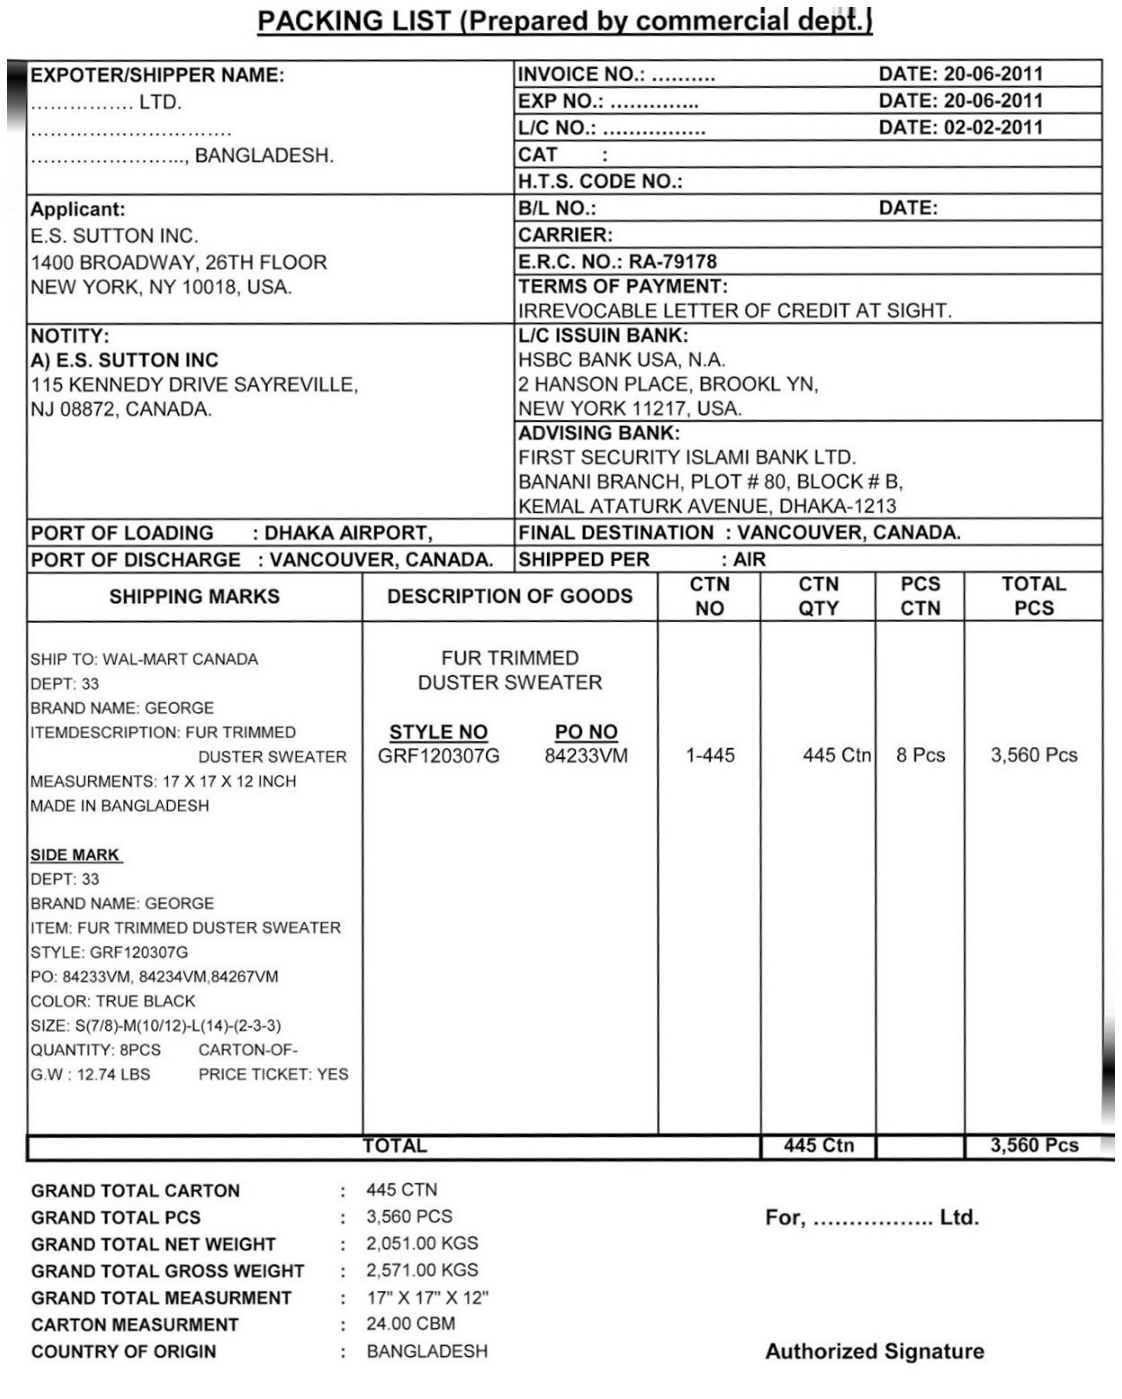

In [14]:
# finally display the aligned image
display_image('/content/drive/My Drive/misaligned_images/5_aligned.jpg')

##5. Transform all images

In [15]:
# now align all the images
parent_dir = '/content/drive/My Drive/misaligned_images/'
image_paths = glob.glob(parent_dir + 'data/*.jpg')

In [16]:
for path in image_paths:
  image = cv2.imread(path)
  align_obj = AlignTextImage(image)
  aligned_image = align_obj.deskew()
  dest_path = parent_dir + 'temp/' + path.split('/')[-1]
  cv2.imwrite(dest_path, aligned_image)